<a href="https://colab.research.google.com/github/ahirsch-github/flight-price-prediction/blob/main/Data_Mining_Flugpreise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro: Flugpreise (London-Frankfurt-Berlin)


In [ ]:
# Python Bibliotheken
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
#lade die Train_csv runter
dataSet = pd.read_csv("/content/Flugticket_Preise/train_set.csv",  # Trainingsdatensatz
                      delimiter = ',',
                      thousands = None,
                      decimal = '.')

# dataSet in ein Pandas DataFrame konvertieren
Train_df = pd.DataFrame(dataSet)
Train_df.head(10)

,index,Request_Date,Flight_Date,Departure_hour,flight_unique_id,route_abb,Price_In_Eur,min_future_price_in_Eur,buy
0,1,2019-06-03T11:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,208.07,259.07,1
1,2,2019-06-03T23:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
2,3,2019-06-04T11:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
3,4,2019-06-04T23:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
4,5,2019-06-03T11:00:00Z,2019-06-05,21,2019-06-05 FR 147,STN-SXF,143.86,251.72,1
5,6,2019-06-03T23:00:00Z,2019-06-05,21,2019-06-05 FR 147,STN-SXF,252.06,251.72,0
6,7,2019-06-04T11:00:00Z,2019-06-05,21,2019-06-05 FR 147,STN-SXF,251.72,251.72,1
7,8,2019-06-04T23:00:00Z,2019-06-05,21,2019-06-05 FR 147,STN-SXF,251.72,251.72,1
8,9,2019-06-03T11:00:00Z,2019-06-05,22,2019-06-05 FR 8545,SXF-STN,22.17,22.17,1
9,10,2019-06-03T23:00:00Z,2019-06-05,22,2019-06-05 FR 8545,SXF-STN,22.17,28.55,1


Daten Intro

In [ ]:

Train_df.describe() # deskriptive zusammengefasste Statistik der Daten
Train_df.dtypes #Datentypen
Train_df.isnull().sum() #checken, ob NULL-Wert vorhanden sind
Train_df.keys() # Alle Spaltennamen (Features)
Train_df.shape #Zeilen: 83624; Spalten: 9

Index(['index', 'Request_Date', 'Flight_Date', 'Departure_hour',
       'flight_unique_id', 'route_abb', 'Price_In_Eur',
       'min_future_price_in_Eur', 'buy'],
      dtype='object')
(83624, 9)


In [ ]:
# Zählen wie viele Strecken es gibt (London-Frankfurt; Frankfurt, London-Berlin; Berlin-London)
Train_df["route_abb"].value_counts()

#visualiseren ?
# Die Flugtstrecken Encoden in: Frankfurt-London (0), London-Frankfurt (1), Berlin-London (2), London-Berlin (3)

SXF-STN    27592
STN-SXF    26489
FRA-STN    14950
STN-FRA    14593
Name: route_abb, dtype: int64

In [ ]:


#Prepare Date Data
Train_df["journey_day"] = pd.to_datetime(Train_df.Request_Date, format="%Y-%m-%dT%H:%M:%SZ").dt.day #Tag
Train_df["month"] = pd.to_datetime(Train_df.Request_Date, format="%Y-%m-%dT%H:%M:%SZ").dt.month #Monat
Train_df["weekday"] = pd.to_datetime(Train_df.Request_Date, format="%Y-%m-%dT%H:%M:%SZ").dt.strftime('%A') #Wochentag

# Vielleicht noch Stunde und Minute extrahieren -> damit könnte man Morgen, Mittag und Abends labeln
#Für Nominale Daten: One-Hot-Encoding; für ordinale Daten: LabelEncoder


#Jahreszeiten aus dem Datenset generieren
def get_jahreszeit(datum):
    fruehling = range(80, 172)   # 20. März bis 20. Juni
    sommer = range(172, 264)     # 21. Juni bis 21. September
    herbst = range(264, 355)     # 22. September bis 20. Dezember

    tag_des_jahres = datum.timetuple().tm_yday

    if tag_des_jahres in fruehling:
        return "Frühling"
    elif tag_des_jahres in sommer:
        return "Sommer"
    elif tag_des_jahres in herbst:
        return "Herbst"
    else:
        return "Winter"
Train_df['season'] = Train_df['Request_Date'].apply(lambda x: get_jahreszeit(datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')))
# Daten reichen nur von Juni-August; drin lassen oder rausnehmen ? Würde nur Sommer-Frühling als Label bekommen






In [ ]:
#Korrelationsmatrix:

Korrelationsmatrix = Train_df.corr()
Korrelationsmatrix

<ipython-input-50-bdb34bebe3e1>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Korrelationsmatrix = Train_df.corr()


,index,Departure_hour,Price_In_Eur,min_future_price_in_Eur,buy,journey_day,month
index,1.000000,0.002382,-0.388975,-0.409284,-0.121130,0.115227,0.308520
Departure_hour,0.002382,1.000000,0.092180,0.083496,-0.000522,0.000555,0.003486
Price_In_Eur,-0.388975,0.092180,1.000000,0.894554,-0.038199,0.002850,0.166957
min_future_price_in_Eur,-0.409284,0.083496,0.894554,1.000000,0.197882,0.041787,0.177996
buy,-0.121130,-0.000522,-0.038199,0.197882,1.000000,0.071517,0.095869
journey_day,0.115227,0.000555,0.002850,0.041787,0.071517,1.000000,-0.157656
month,0.308520,0.003486,0.166957,0.177996,0.095869,-0.157656,1.000000


In [ ]:
Train_df.head(10)
y = Train_df.iloc[:, 8]
y

0        1
1        1
2        1
3        1
4        1
        ..
83619    1
83620    0
83621    0
83622    1
83623    1
Name: buy, Length: 83624, dtype: int64

(83624, 5) (83624,)
[0.02554479 0.39950746 0.48272635 0.05432134 0.03790007]


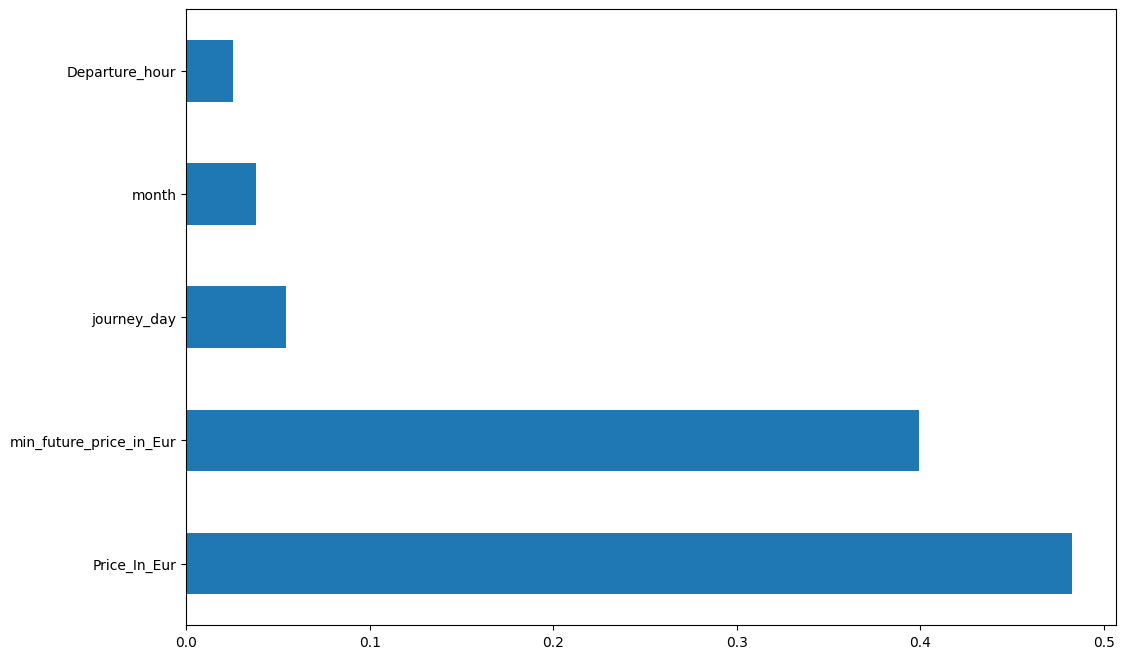

In [ ]:
X = Train_df.loc[:,["Departure_hour", "min_future_price_in_Eur", "Price_In_Eur", "journey_day", "month"]]
y = Train_df.iloc[:, 8]
print(X.shape, y.shape)

# Important feature using ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesRegressor
selection = ExtraTreesRegressor()
selection.fit(X, y)
print(selection.feature_importances_)

# Plot graph of feature importances for better visualization
plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')
plt.show()

In [ ]:
#libary for compute the VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(z):
    # Calculating Variable Inflation Factor (VIF) -> steht dafür wie doll die Prädiktoren mit anderen korrelieren: VIF > 10 eigentlich schlecht
    vif = pd.DataFrame()
    vif["variables"] = z.columns
    vif["VIF"] = [variance_inflation_factor(z.values, i) for i in range(z.shape[1])]
    return(vif)

# Compute VIF on X
calc_vif(X)

,variables,VIF
0,Departure_hour,5.299540
1,min_future_price_in_Eur,12.636540
2,Price_In_Eur,13.726329
3,journey_day,3.813288
4,month,9.047515


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Model training
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)

rf_LR = LinearRegression()
rf_LR.fit(X_train, y_train)

LinearRegression()

AttributeError: ignored